In [176]:
import chess
import chess.pgn
from chess import Board, Move
from enum import Enum
import io
import itertools
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from torch.utils.data import Dataset, DataLoader
from typing import Iterator, List

In [2]:
POSTGRES_HOSTNAME=os.environ["POSTGRES_HOSTNAME"]
POSTGRES_DATABASE=os.environ["POSTGRES_DATABASE"]
POSTGRES_USERNAME=os.environ["POSTGRES_USERNAME"]
POSTGRES_PASSWORD=os.environ["POSTGRES_PASSWORD"]

In [3]:
DATABASE_URL = f"postgresql+psycopg2://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}/{POSTGRES_DATABASE}"


# Set up SQLAlchemy base and session
engine = create_engine(DATABASE_URL)

In [192]:
with engine.connect() as session, session.begin():
    games = pd.read_sql_table("games", session)

In [5]:
# Define piece to integer mapping
piece_to_int = {
    None: 0,  # Empty square
    chess.PAWN: 1,
    chess.KNIGHT: 2,
    chess.BISHOP: 3,
    chess.ROOK: 4,
    chess.QUEEN: 5,
    chess.KING: 6
}

In [6]:
# Separate for white and black pieces
piece_to_int_white = {piece: val for piece, val in piece_to_int.items()}
piece_to_int_black = {piece: -val for piece, val in piece_to_int.items()}

In [7]:
def get_board_array(board: Board) -> np.ndarray:
    board_array = np.zeros((8, 8), dtype=int)

    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece:
            row, col = divmod(square, 8)

            if piece.color == chess.WHITE:
                board_array[row, col] = piece_to_int_white[piece.piece_type]
            else:
                board_array[row, col] = piece_to_int_black[piece.piece_type]

    return board_array

In [115]:
def make_move(board:Board, moves:Iterator) -> Move:
    next_move = next(moves, None)

    if next_move:
        board.push(next_move)

    return next_move

In [193]:
games

,game_id,lichess_game_id,site,date,round,white,black,white_elo,black_elo,winner,pgn,eco
0,1,RTZfgncTSbexaiNnmXgUKw,SocialChess,2020-12-31,-,6,NaN,1311,1282,6,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C40
1,2,loVB87mxTwG8tm461lgHZg,SocialChess,2021-01-05,-,7,6.0,1284,1224,7,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C41
2,3,RTZfgncTSbexaiNnmXgUKw,SocialChess,2020-12-31,-,6,7.0,1311,1282,6,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C40
3,4,loVB87mxTwG8tm461lgHZg,SocialChess,2021-01-05,-,7,6.0,1284,1224,7,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C41
4,5,QYHv3_CPQ76F4cxek8eF1w,SocialChess,2021-01-10,-,6,7.0,1306,1282,6,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C46
...,...,...,...,...,...,...,...,...,...,...,...,...
196,198,euGLlYGmSiO9nLVFLRjTew,SocialChess,2024-06-19,-,6,7.0,1231,1236,7,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C47
197,199,AqUOGqEWS-qAAXBgtzsThA,SocialChess,2024-06-22,-,7,6.0,1252,1215,7,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C47
198,200,0Dh4bntUSN-FKwb-4f3bVw,SocialChess,2024-09-16,-,7,6.0,1234,1233,6,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C44
199,201,sKy08-qdSYKSy1WW2ti9LA,SocialChess,2024-09-30,-,6,7.0,1249,1218,6,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C46


In [119]:
pgn_game_1 = io.StringIO(games["pgn"][0])
pgn_game_1

In [120]:
game_1 = chess.pgn.read_game(pgn_game_1)
game_1

<Game at 0x168c40b50 ('ministeroffinance' vs. 'Mike 0787', '2020.12.31' at 'SocialChess')>

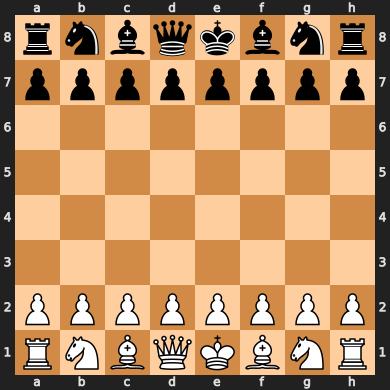

In [121]:
board = game_1.board()
board

In [122]:
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [123]:
moves = iter(game_1.mainline_moves())
moves

<generator object Mainline.__iter__ at 0x168c4ea50>

In [124]:
board_array = get_board_array(board)
board_array

array([[ 4,  2,  3,  5,  6,  3,  2,  4],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-4, -2, -3, -5, -6, -3, -2, -4]])

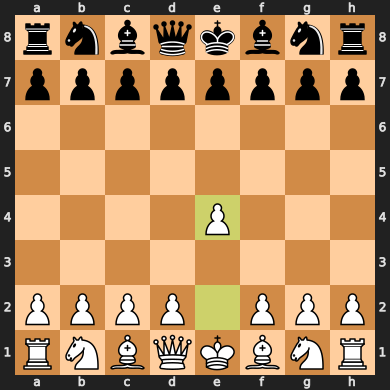

In [125]:
make_move(board, moves)
board

In [126]:
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


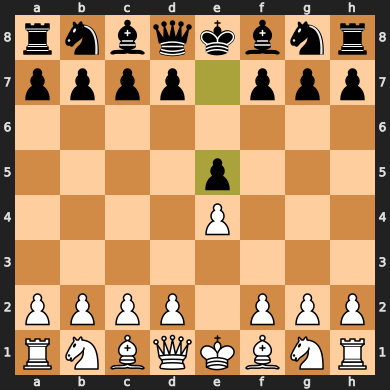

In [127]:
make_move(board, moves)
board

In [128]:
print(board)

r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


In [129]:
board_array = get_board_array(board)
board_array

array([[ 4,  2,  3,  5,  6,  3,  2,  4],
       [ 1,  1,  1,  1,  0,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1,  0, -1, -1, -1],
       [-4, -2, -3, -5, -6, -3, -2, -4]])

In [130]:
# TODO - Import from dao project in github package registry or maybe artifactory
class Player(Enum):
    WHITE = 1
    BLACK = -1

In [131]:
def get_players_turn_array(player: Player) -> np.ndarray:
    return np.full((8, 8), player.value)

In [132]:
white_players_turn = get_players_turn_array(Player.WHITE)
white_players_turn

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]])

In [133]:
black_players_turn = get_players_turn_array(Player.BLACK)
black_players_turn

array([[-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1]])

In [134]:
input_tensor = np.stack([board_array, black_players_turn], axis=0)
input_tensor

array([[[ 4,  2,  3,  5,  6,  3,  2,  4],
        [ 1,  1,  1,  1,  0,  1,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0, -1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [-1, -1, -1, -1,  0, -1, -1, -1],
        [-4, -2, -3, -5, -6, -3, -2, -4]],

       [[-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1]]])

In [135]:
board_array

array([[ 4,  2,  3,  5,  6,  3,  2,  4],
       [ 1,  1,  1,  1,  0,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1,  0, -1, -1, -1],
       [-4, -2, -3, -5, -6, -3, -2, -4]])

In [136]:
FILES = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
RANKS = ['1', '2', '3', '4', '5', '6', '7', '8']
PROMOTION_PIECES = ['q', 'r', 'b', 'n']

In [137]:
def get_chess_board_layout():
    return ["".join(square) for square in itertools.product(FILES, RANKS)]

In [138]:
chess_board_layout = get_chess_board_layout()
chess_board_layout

['a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'b8',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'd1',
 'd2',
 'd3',
 'd4',
 'd5',
 'd6',
 'd7',
 'd8',
 'e1',
 'e2',
 'e3',
 'e4',
 'e5',
 'e6',
 'e7',
 'e8',
 'f1',
 'f2',
 'f3',
 'f4',
 'f5',
 'f6',
 'f7',
 'f8',
 'g1',
 'g2',
 'g3',
 'g4',
 'g5',
 'g6',
 'g7',
 'g8',
 'h1',
 'h2',
 'h3',
 'h4',
 'h5',
 'h6',
 'h7',
 'h8']

In [139]:
def generate_standard_possible_moves():
    board_layout = get_chess_board_layout()

    return ["".join(move) for move in itertools.product(chess_board_layout, chess_board_layout)]

In [140]:
standard_possible_moves = generate_standard_possible_moves()
standard_possible_moves

['a1a1',
 'a1a2',
 'a1a3',
 'a1a4',
 'a1a5',
 'a1a6',
 'a1a7',
 'a1a8',
 'a1b1',
 'a1b2',
 'a1b3',
 'a1b4',
 'a1b5',
 'a1b6',
 'a1b7',
 'a1b8',
 'a1c1',
 'a1c2',
 'a1c3',
 'a1c4',
 'a1c5',
 'a1c6',
 'a1c7',
 'a1c8',
 'a1d1',
 'a1d2',
 'a1d3',
 'a1d4',
 'a1d5',
 'a1d6',
 'a1d7',
 'a1d8',
 'a1e1',
 'a1e2',
 'a1e3',
 'a1e4',
 'a1e5',
 'a1e6',
 'a1e7',
 'a1e8',
 'a1f1',
 'a1f2',
 'a1f3',
 'a1f4',
 'a1f5',
 'a1f6',
 'a1f7',
 'a1f8',
 'a1g1',
 'a1g2',
 'a1g3',
 'a1g4',
 'a1g5',
 'a1g6',
 'a1g7',
 'a1g8',
 'a1h1',
 'a1h2',
 'a1h3',
 'a1h4',
 'a1h5',
 'a1h6',
 'a1h7',
 'a1h8',
 'a2a1',
 'a2a2',
 'a2a3',
 'a2a4',
 'a2a5',
 'a2a6',
 'a2a7',
 'a2a8',
 'a2b1',
 'a2b2',
 'a2b3',
 'a2b4',
 'a2b5',
 'a2b6',
 'a2b7',
 'a2b8',
 'a2c1',
 'a2c2',
 'a2c3',
 'a2c4',
 'a2c5',
 'a2c6',
 'a2c7',
 'a2c8',
 'a2d1',
 'a2d2',
 'a2d3',
 'a2d4',
 'a2d5',
 'a2d6',
 'a2d7',
 'a2d8',
 'a2e1',
 'a2e2',
 'a2e3',
 'a2e4',
 'a2e5',
 'a2e6',
 'a2e7',
 'a2e8',
 'a2f1',
 'a2f2',
 'a2f3',
 'a2f4',
 'a2f5',
 'a2f6',
 'a2f7',
 

In [141]:
def generate_all_possible_white_promotion_moves():
    white_promotion_moves = []
    
    for file in FILES:
        for piece in PROMOTION_PIECES:
            white_promotion_moves.append(f"{file}7{file}8{piece}")
        
    return white_promotion_moves

In [142]:
white_promotion_moves = generate_all_possible_white_promotion_moves()
white_promotion_moves

['a7a8q',
 'a7a8r',
 'a7a8b',
 'a7a8n',
 'b7b8q',
 'b7b8r',
 'b7b8b',
 'b7b8n',
 'c7c8q',
 'c7c8r',
 'c7c8b',
 'c7c8n',
 'd7d8q',
 'd7d8r',
 'd7d8b',
 'd7d8n',
 'e7e8q',
 'e7e8r',
 'e7e8b',
 'e7e8n',
 'f7f8q',
 'f7f8r',
 'f7f8b',
 'f7f8n',
 'g7g8q',
 'g7g8r',
 'g7g8b',
 'g7g8n',
 'h7h8q',
 'h7h8r',
 'h7h8b',
 'h7h8n']

In [143]:
def generate_all_possible_black_promotion_moves():
    black_promotion_moves = []
    
    for file in FILES:
        for piece in PROMOTION_PIECES:
            black_promotion_moves.append(f"{file}2{file}1{piece}")
        
    return black_promotion_moves

In [144]:
black_promotion_moves = generate_all_possible_black_promotion_moves()
black_promotion_moves

['a2a1q',
 'a2a1r',
 'a2a1b',
 'a2a1n',
 'b2b1q',
 'b2b1r',
 'b2b1b',
 'b2b1n',
 'c2c1q',
 'c2c1r',
 'c2c1b',
 'c2c1n',
 'd2d1q',
 'd2d1r',
 'd2d1b',
 'd2d1n',
 'e2e1q',
 'e2e1r',
 'e2e1b',
 'e2e1n',
 'f2f1q',
 'f2f1r',
 'f2f1b',
 'f2f1n',
 'g2g1q',
 'g2g1r',
 'g2g1b',
 'g2g1n',
 'h2h1q',
 'h2h1r',
 'h2h1b',
 'h2h1n']

In [145]:
def generate_black_castling():
    castling = []
    castling.append("e8g8")  # Black kingside castling
    castling.append("e8c8")  # Black queenside castling

    return castling

In [146]:
black_castling = generate_black_castling()
black_castling

['e8g8', 'e8c8']

In [147]:
def generate_white_castling():
    castling = []
    castling.append("e1g1")  # White kingside castling
    castling.append("e1c1")  # White queenside castling

    return castling

In [148]:
white_castling = generate_white_castling()
white_castling

['e1g1', 'e1c1']

In [149]:
board.legal_moves

<LegalMoveGenerator at 0x168c4f220 (Nh3, Nf3, Ne2, Ba6, Bb5, Bc4, Bd3, Be2, Ke2, Qh5, Qg4, Qf3, Qe2, Nc3, Na3, h3, g3, f3, d3, c3, b3, a3, h4, g4, f4, d4, c4, b4, a4)>

In [150]:
legal_moves = list(board.legal_moves)
legal_moves

[Move.from_uci('g1h3'),
 Move.from_uci('g1f3'),
 Move.from_uci('g1e2'),
 Move.from_uci('f1a6'),
 Move.from_uci('f1b5'),
 Move.from_uci('f1c4'),
 Move.from_uci('f1d3'),
 Move.from_uci('f1e2'),
 Move.from_uci('e1e2'),
 Move.from_uci('d1h5'),
 Move.from_uci('d1g4'),
 Move.from_uci('d1f3'),
 Move.from_uci('d1e2'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1a3'),
 Move.from_uci('h2h3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f2f3'),
 Move.from_uci('d2d3'),
 Move.from_uci('c2c3'),
 Move.from_uci('b2b3'),
 Move.from_uci('a2a3'),
 Move.from_uci('h2h4'),
 Move.from_uci('g2g4'),
 Move.from_uci('f2f4'),
 Move.from_uci('d2d4'),
 Move.from_uci('c2c4'),
 Move.from_uci('b2b4'),
 Move.from_uci('a2a4')]

In [151]:
legal_uci_moves = [move.uci() for move in legal_moves]
legal_uci_moves

['g1h3',
 'g1f3',
 'g1e2',
 'f1a6',
 'f1b5',
 'f1c4',
 'f1d3',
 'f1e2',
 'e1e2',
 'd1h5',
 'd1g4',
 'd1f3',
 'd1e2',
 'b1c3',
 'b1a3',
 'h2h3',
 'g2g3',
 'f2f3',
 'd2d3',
 'c2c3',
 'b2b3',
 'a2a3',
 'h2h4',
 'g2g4',
 'f2f4',
 'd2d4',
 'c2c4',
 'b2b4',
 'a2a4']

In [152]:
def generate_all_possible_moves():
        running_moves = generate_standard_possible_moves()
        running_moves.append(generate_all_possible_white_promotion_moves())
        running_moves.append(generate_all_possible_black_promotion_moves())
        running_moves.append(generate_black_castling())
        running_moves.append(generate_white_castling())
        
        # En passant moves will be added dynamically during training due to the predicted move en passant move label
        # This is due in large part because this particular chess depends on the chess board state
        # and cannot be statically generated from possible moves for the possible move logits

        return running_moves

In [153]:
possible_moves = generate_all_possible_moves()
possible_moves

['a1a1',
 'a1a2',
 'a1a3',
 'a1a4',
 'a1a5',
 'a1a6',
 'a1a7',
 'a1a8',
 'a1b1',
 'a1b2',
 'a1b3',
 'a1b4',
 'a1b5',
 'a1b6',
 'a1b7',
 'a1b8',
 'a1c1',
 'a1c2',
 'a1c3',
 'a1c4',
 'a1c5',
 'a1c6',
 'a1c7',
 'a1c8',
 'a1d1',
 'a1d2',
 'a1d3',
 'a1d4',
 'a1d5',
 'a1d6',
 'a1d7',
 'a1d8',
 'a1e1',
 'a1e2',
 'a1e3',
 'a1e4',
 'a1e5',
 'a1e6',
 'a1e7',
 'a1e8',
 'a1f1',
 'a1f2',
 'a1f3',
 'a1f4',
 'a1f5',
 'a1f6',
 'a1f7',
 'a1f8',
 'a1g1',
 'a1g2',
 'a1g3',
 'a1g4',
 'a1g5',
 'a1g6',
 'a1g7',
 'a1g8',
 'a1h1',
 'a1h2',
 'a1h3',
 'a1h4',
 'a1h5',
 'a1h6',
 'a1h7',
 'a1h8',
 'a2a1',
 'a2a2',
 'a2a3',
 'a2a4',
 'a2a5',
 'a2a6',
 'a2a7',
 'a2a8',
 'a2b1',
 'a2b2',
 'a2b3',
 'a2b4',
 'a2b5',
 'a2b6',
 'a2b7',
 'a2b8',
 'a2c1',
 'a2c2',
 'a2c3',
 'a2c4',
 'a2c5',
 'a2c6',
 'a2c7',
 'a2c8',
 'a2d1',
 'a2d2',
 'a2d3',
 'a2d4',
 'a2d5',
 'a2d6',
 'a2d7',
 'a2d8',
 'a2e1',
 'a2e2',
 'a2e3',
 'a2e4',
 'a2e5',
 'a2e6',
 'a2e7',
 'a2e8',
 'a2f1',
 'a2f2',
 'a2f3',
 'a2f4',
 'a2f5',
 'a2f6',
 'a2f7',
 

In [155]:
move_mask = np.zeros(len(possible_moves))
move_mask

array([0., 0., 0., ..., 0., 0., 0.])

In [156]:
for i, move in enumerate(possible_moves):
    if move in legal_uci_moves:
        move_mask[i] = 1

In [157]:
move_mask

array([0., 0., 0., ..., 0., 0., 0.])

In [158]:
indices = np.where(move_mask == 1)[0]
indices

array([  66,   67,  514,  530,  586,  587, 1106, 1107, 1569, 1578, 1587,
       1596, 1626, 1627, 2081, 2565, 2572, 2579, 2586, 2593, 2666, 2667,
       3105, 3114, 3130, 3186, 3187, 3706, 3707])

In [159]:
type(legal_uci_moves)

list

In [160]:
len(legal_uci_moves)

29

In [161]:
for i in indices:
    print(possible_moves[i])

a2a3
a2a4
b1a3
b1c3
b2b3
b2b4
c2c3
c2c4
d1e2
d1f3
d1g4
d1h5
d2d3
d2d4
e1e2
f1a6
f1b5
f1c4
f1d3
f1e2
f2f3
f2f4
g1e2
g1f3
g1h3
g2g3
g2g4
h2h3
h2h4


In [162]:
move = make_move(board, moves)
move

Move.from_uci('g1f3')

In [163]:
move

Move.from_uci('g1f3')

In [164]:
move = make_move(board, moves)
move

Move.from_uci('d7d5')

moves

In [165]:
moves

<generator object Mainline.__iter__ at 0x168c4ea50>

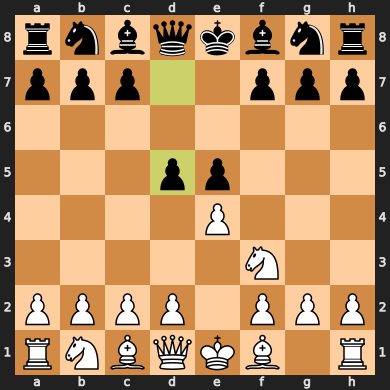

In [166]:
board

In [167]:
len(possible_moves)

4100

In [169]:
type(possible_moves[0])

str

In [172]:
def get_move_mask(possible_moves: List[str]) -> np.ndarray:
    move_mask = np.zeros(len(possible_moves))

    for i, move in enumerate(possible_moves):
        if move in legal_uci_moves:
            move_mask[i] = 1

    return move_mask

In [179]:
PGN_COLUMN = "pgn"

In [213]:
class ChessDataset(Dataset):
    def __init__(self, games: DataFrame):
        self.games_dataset = games[PGN_COLUMN].tolist()

    def __len__(self):
        return len(self.games_dataset)

    def __getitem__(self, idx):
        game_dataset = chess.pgn.read_game(io.StringIO(self.dataset_games[idx]))

        board_dataset = game_dataset.board()
        dataset_moves = list(dataset_game.mainline_moves())

        dataset_game_boards, dataset_move_masks, dataset_move_labels = [], [], []

        for dataset_move in dataset_moves:
            board_array_dataset = get_board_array(board_dataset)

            if dataset_board.turn: 
                players_turn_dataset = get_players_turn_array(Player.WHITE)
            else: 
                players_turn_dataset = get_players_turn_array(Player.BLACK)

            input_features = np.stack([board_array_dataset, players_turn_dataset], axis=0)
                
            print(players_turn_dataset)

        return dataset_moves

In [214]:
chess_dataset = ChessDataset(games)
chess_dataset

In [215]:
chess_dataset.__getitem__(0)

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 

[Move.from_uci('e2e4'),
 Move.from_uci('e7e5'),
 Move.from_uci('g1f3'),
 Move.from_uci('d7d5'),
 Move.from_uci('f3e5'),
 Move.from_uci('d8e7'),
 Move.from_uci('f2f4'),
 Move.from_uci('d5e4'),
 Move.from_uci('d1e2'),
 Move.from_uci('c8f5'),
 Move.from_uci('g2g4'),
 Move.from_uci('e7h4'),
 Move.from_uci('e1d1'),
 Move.from_uci('f5d7'),
 Move.from_uci('e2e4'),
 Move.from_uci('h4e7'),
 Move.from_uci('e4b7'),
 Move.from_uci('g7g5'),
 Move.from_uci('b7a8'),
 Move.from_uci('e7e6'),
 Move.from_uci('a8b8'),
 Move.from_uci('d7c8'),
 Move.from_uci('d1e1'),
 Move.from_uci('g5f4'),
 Move.from_uci('d2d4'),
 Move.from_uci('f8d6'),
 Move.from_uci('f1c4'),
 Move.from_uci('e6e7'),
 Move.from_uci('b8c8'),
 Move.from_uci('e7d8'),
 Move.from_uci('c4b5'),
 Move.from_uci('e8e7'),
 Move.from_uci('e5g6'),
 Move.from_uci('f7g6'),
 Move.from_uci('b5a6'),
 Move.from_uci('d8c8'),
 Move.from_uci('a6c8'),
 Move.from_uci('g8f6'),
 Move.from_uci('g4g5'),
 Move.from_uci('f6e4'),
 Move.from_uci('e1e2'),
 Move.from_uci('